**Importing libraries**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import os
print(os.listdir("../input/cell_images/cell_images/"))

['Uninfected', 'Parasitized']


> Use the GPU if available for computations.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data Augmentation

* > Using Pytorch transformation function to augment a dataset. I tried different transformations but find these helpful.
* > All the images are resized to 120 * 120 as an input to custom CNN class.
* > Applying different transformations like RandomHorizontalFlip( ), RandomRotation( ) etc. There is a 50/50 chance whether it would change the image or not.
* > Converting images into Pytorch tensors.
* > Also normalizing them with mean [0.5, 0.5., 0.5] and standard deviation [0.5, 0.5, 0.5]. All tensors are in range of [-1, 1].
    > It won't increase size of the dataset as transformation performs one by one on images.

In [3]:
train_transforms = transforms.Compose([transforms.Resize((120, 120)),
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

> Loading a images using generic dataloader ImageFolder.

In [4]:
image_dir = "../input/cell_images/cell_images/"
train_set = datasets.ImageFolder(image_dir, transform=train_transforms)

### Creating a dataset

In [5]:
test_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

test_split = int(np.floor((test_size) * num_train))
test_index, train_index = indices[:test_split - 1], indices[test_split - 1:]

train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=104)
test_loader = DataLoader(train_set, sampler=test_sampler, batch_size=58)
print("Images in Test set: {}\nImages in Train set: {}".format(len(test_index), len(train_index)))

Images in Test set: 5510
Images in Train set: 22048


> We have images in 2 classes: Infected and Uninfected

In [6]:
classes=['infected','uninfected']

> Visualizing some Images...

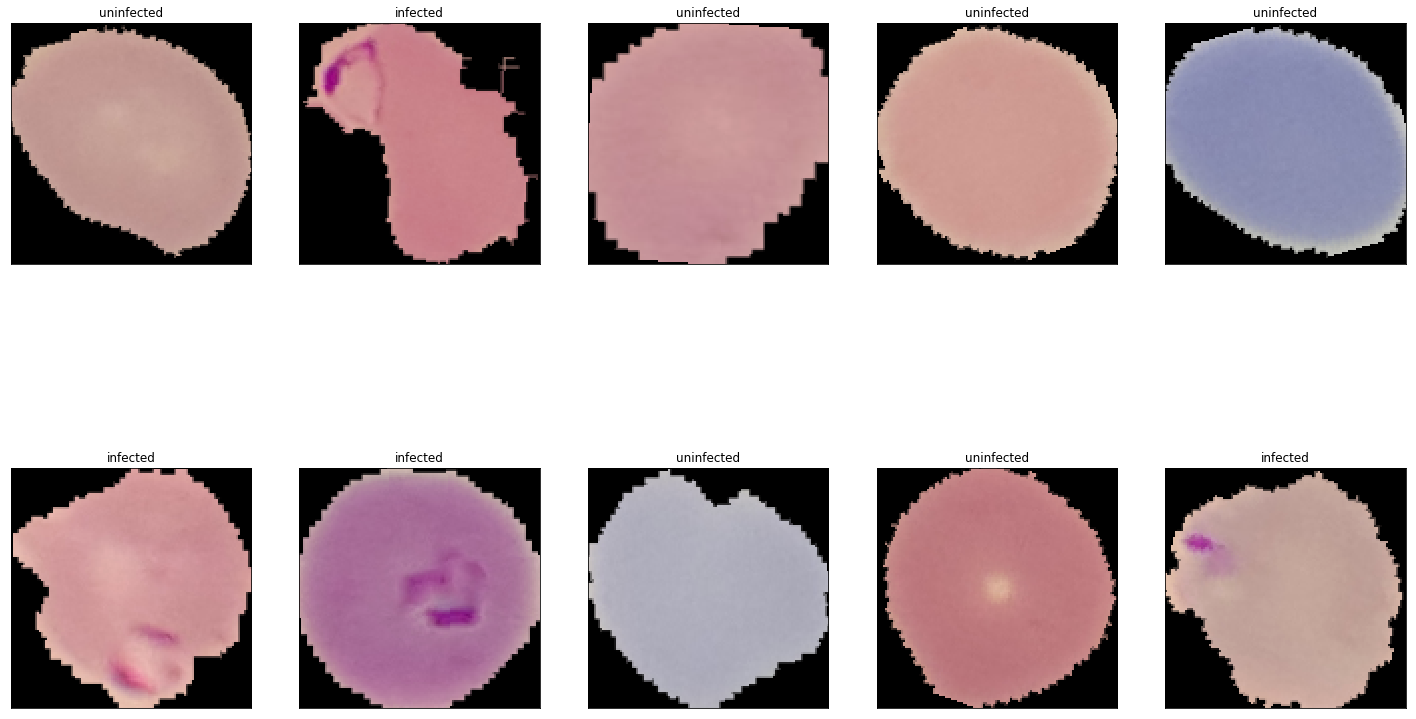

In [7]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

### CNN class
* Creating a CNN class as MosquitoNet.
* It has following layers:
    * 3 Convolutional layers with MaxPooling (Stride 2)
    * All 3 convulations are "Same Convolution with some zero-padding"
    * 3 FullyConnected Layers
* BatchNormalization is used after convulations 
* ReLU is used as a activation function
* Dropout is used with p = 0.5

* Images are changed from input to output layers in following way:
    * In Layer 1 : Input: 120 \* 120 \* 3, Output: 60 \* 60 \* 16
    * In Layer 2 : Input: 60 \* 60 \* 16, Output: 30 \* 30 \* 32
    * In Layer 3 : Input: 30 \* 30 \* 32, Output: 15 \* 15 \* 64
    * In FC1 : Input: 14440, Output: 512
    * In FC2 : Input: 512, Output: 128
    * In FC3 : Input: 128, Output: 2

In [8]:
class MosquitoNet(nn.Module):
    
    def __init__(self):
        super(MosquitoNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
            
        self.fc1 = nn.Linear(64*15*15, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)    # flatten out a input for Dense Layer
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc3(out)
        
        return out
        

> Making a model and defining error and optimizing algorithm.

In [9]:
model = MosquitoNet()
model.to(device)
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

MosquitoNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=14400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=12

### Training a Model

In [10]:
num_epochs = 20
batch_size = 100 

for epoch in range(num_epochs):
    train_loss = 0.
    model.train()    # explictily stating the training
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        train = images.view(-1, 3, 120, 120)
        outputs = model(train)
        
        optimizer.zero_grad()
        loss = error(outputs, labels)
        loss.backward()    #back-propagation
        optimizer.step()
        
        train_loss += loss.item() * batch_size
     
    print("Epoch: {}, Loss: {:.4f}".format(epoch + 1, train_loss / len(train_loader.dataset)))

Epoch: 1, Loss: 0.3043
Epoch: 2, Loss: 0.1336
Epoch: 3, Loss: 0.1168
Epoch: 4, Loss: 0.1102
Epoch: 5, Loss: 0.1043
Epoch: 6, Loss: 0.1018
Epoch: 7, Loss: 0.1007
Epoch: 8, Loss: 0.0976
Epoch: 9, Loss: 0.0941
Epoch: 10, Loss: 0.0921
Epoch: 11, Loss: 0.0913
Epoch: 12, Loss: 0.0879
Epoch: 13, Loss: 0.0897
Epoch: 14, Loss: 0.0864
Epoch: 15, Loss: 0.0849
Epoch: 16, Loss: 0.0829
Epoch: 17, Loss: 0.0833
Epoch: 18, Loss: 0.0822
Epoch: 19, Loss: 0.0803
Epoch: 20, Loss: 0.0828


> Saving a model in disk

In [11]:
torch.save(model.state_dict(), "model.pt")

### Testing a model

In [12]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 96.55%

Accuracy of infected :  96.39%   [2696 / 2797]
Accuracy of uninfected :  96.72%   [2624 / 2713]


> Calculating a Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

#flatten out 2D list into 1D
actual = list(itertools.chain.from_iterable(actual))
predict = list(itertools.chain.from_iterable(predict))


In [14]:
results = confusion_matrix(actual, predict)
print("Accuracy Score: ")
print("{:.4f}".format(accuracy_score(actual, predict)))
print()
print("Report: ")
print(classification_report(actual, predict))
print()
print("Confusion Matrix: ")
print(pd.DataFrame(results, columns=["Predicted No", "Predicted Yes"], index=["Actual No", "Actual Yes"]))

Accuracy Score: 
0.9655

Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2797
           1       0.96      0.97      0.97      2713

   micro avg       0.97      0.97      0.97      5510
   macro avg       0.97      0.97      0.97      5510
weighted avg       0.97      0.97      0.97      5510


Confusion Matrix: 
            Predicted No  Predicted Yes
Actual No           2696            101
Actual Yes            89           2624


> Displaying it as a plot

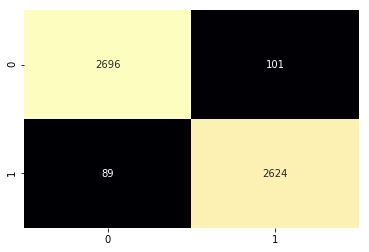

In [15]:
import seaborn as sns

sns.heatmap(results, cmap="magma", annot=True, fmt="d", cbar=False)